# 1. Marketing Mix Modelling with LightweightMMM

[описание в библеоткеке Robyn](https://facebookexperimental.github.io/Robyn/docs/analysts-guide-to-MMM)
*   How much sales (online and offline) did each media channel drive?
*   What was the ROI of each marketing channel?
*   How should I allocate budget by channel so as to maximize my KPIs?
*   Where should my next marketing dollar go?
*   What is the optimal level of spend for each major marketing channel?
*   How would sales be impacted if I made X change to my marketing plan?
*   If I needed to cut my marketing budget by X%, where should the dollars come from?
*   How is performance of channels such as FB impacted by the way they are executed (e.g., buying objective, frequency, creative quality or targeting strategy used)?
*   Should we raise our prices? If so, by how much?
*   What is the impact of competitor advertising on the performance of our brands?
*   How much incremental revenue to trade and promotional activities drive?


[параметризация MMM-модели в библиотеке LightweightMMM](https://lightweight-mmm.readthedocs.io/en/latest/models.html)

[PyMC -- самый хайповый пакет с GPT](https://github.com/pymc-labs/pymc-marketing)

[репо с разными подходами -- от Ridge до Байесса](https://github.com/slavakx/medium_posts/)

In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_requirements_lmmm.txt

--2025-03-14 18:35:17--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_requirements_lmmm.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224 [text/plain]
Saving to: ‘MMM_requirements_lmmm.txt.1’

MMM_requirements_lm 100%[===================>]     224  --.-KB/s    in 0s      

2025-03-14 18:35:17 (3.63 MB/s) - ‘MMM_requirements_lmmm.txt.1’ saved [224/224]



In [ ]:
!pip uninstall -y -q plotnine bigframes

In [ ]:
!pip install -q -r MMM_requirements_lmmm.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.6.1 which is incompatible.
bigframes 1.38.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.1 which is incompatible.


In [ ]:
!pip install -q jax==0.4.18 jaxlib==0.4.18

In [ ]:
from lightweight_mmm.utils import simulate_dummy_data
from lightweight_mmm.preprocessing import CustomScaler
from lightweight_mmm.lightweight_mmm import LightweightMMM
import jax.numpy as jnp
from numpyro import distributions, set_host_device_count
set_host_device_count(2)
from lightweight_mmm.plot import plot_model_fit, plot_media_channel_posteriors, plot_response_curves, plot_bars_media_metrics, plot_out_of_sample_model_fit, plot_prior_and_posterior
from lightweight_mmm.optimize_media import find_optimal_budgets
import numpy as np

## Сгенерим синтетики

In [ ]:
data_size = 250
media_names = ['tv', 'digital', 'paper', 'blogers', 'social_nets']
media_data, extra_features, target, costs = simulate_dummy_data(
    seed=43,
    data_size=data_size,
    n_media_channels=len(media_names),
    n_extra_features=2,
    geos=1)

In [ ]:
costs

Array([500.94504, 496.7451 , 500.5604 , 501.61826, 502.14673], dtype=float32)

что на вход

*   таргет (продажи / офлайн траффик / траффик на сайт etc)
*   внешние фичи -- макро-факторы, погода и пр
*   сезонность (уже в модели)
*   медиа данные двух типов:
  *   медиа инвестиции (сколько по периодам на конкретные каналы тратили -- например еженедельно на какой канал сколько тратили)
  *   медиа показатели (dig: impressions, tv: TRP -- target rating points, audience)

In [ ]:
# Simple split of the data based on time.
split_point = data_size - data_size // 10

media_data_train = media_data[:split_point, :]
target_train = target[:split_point]
extra_features_train = extra_features[:split_point, :]

extra_features_test = extra_features[split_point:, :]
target_test = target[split_point:]
media_data_test = media_data[split_point:, :]

# Scale data
media_scaler = CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = CustomScaler(divide_operation=jnp.mean)
target_scaler = CustomScaler(divide_operation=jnp.mean)
cost_scaler = CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs_scaled = cost_scaler.fit_transform(costs)

media_data_test = media_scaler.transform(media_data_test)
#target_test = target_scaler.transform(target_test)
extra_features_test = extra_features_scaler.transform(extra_features_test)

In [ ]:
# Fit model.
mmm = LightweightMMM(model_name = 'carryover') # carryover, adstock, hill_adstock
mmm.media_names = media_names
mmm.fit(media=media_data_train,
        media_names=media_names,
        extra_features=extra_features_train,
        media_prior=costs_scaled,
        target=target_train,
        number_warmup=2000,
        number_samples=2000,
        number_chains=1,
        seed = 42)

sample: 100%|██████████| 4000/4000 [08:55<00:00,  7.47it/s, 255 steps of size 1.29e-02. acc. prob=0.95]


At every sampler iteration, the sampler returns a set of estimates for all parameters and quantities of interest in the model. During warmup, the NUTS algorithm adjusts the HMC algorithm parameters metric and stepsize in order to efficiently sample from typical set, the neighborhood substantial posterior probability mass through which the Markov chain will travel in equilibrium. After warmup, the fixed metric and stepsize are used to produce a set of draws.

In [ ]:
costs_scaled

Array([1.0010829, 0.9926898, 1.0003142, 1.0024283, 1.0034844], dtype=float32)

In [ ]:
mmm.print_summary()
# The rule of thumb is that r_hat values for all parameters are less than 1.1.


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.37      0.28      0.30      0.00      0.80   1404.29      1.00
ad_effect_retention_rate[1]      0.26      0.15      0.25      0.03      0.49   1655.33      1.00
ad_effect_retention_rate[2]      0.39      0.27      0.35      0.00      0.79   1498.03      1.00
ad_effect_retention_rate[3]      0.39      0.27      0.36      0.00      0.79   1987.20      1.00
ad_effect_retention_rate[4]      0.29      0.15      0.28      0.04      0.53    851.29      1.00
     coef_extra_features[0]     -0.03      0.01     -0.03     -0.04     -0.02   2310.58      1.00
     coef_extra_features[1]      0.01      0.01      0.01     -0.00      0.01   2333.38      1.00
              coef_media[0]      0.01      0.01      0.01      0.00      0.03    853.16      1.00
              coef_media[1]      0.10      0.03      0.10      0.06      0.14   1354.84      1.00
              coef_

Что такое r_hat?    
Статистика Гельмана-Рубина.   
Для интересующихся вот [критерии сходимости](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html).    
там же и про n_eff

Если коротко, то критерий такой:


  * n_eff - crude measure of effective sample size. The low value for the effective sample size (n_eff), particularly for tau, and the number of divergent transitions looks problematic.
  *   r_hat - potential scale reduction factor on split chains. The values above 1 for the split Gelman Rubin diagnostic (r_hat) indicates that the chain has not fully converged.

Почему MCMC для семплирования/ оптимизации используют когда пространство плохое (например ввиду мультиколлинеарности) -- [введение в вероятности, стр. 536](https://drive.google.com/file/d/1VmkAAGOYCTORq1wxSQqy255qLJjTNvBI/view)

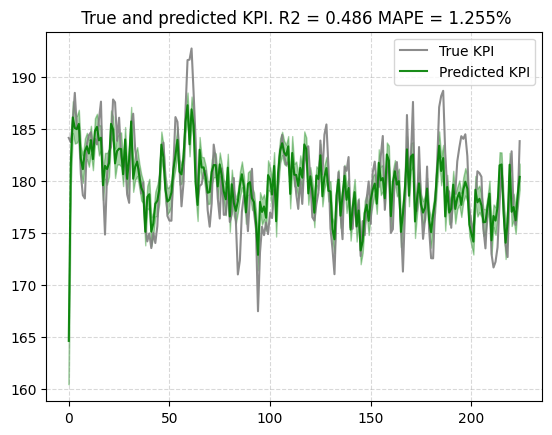

In [ ]:
plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

In [ ]:
prediction = mmm.predict(
    media=media_data_test,
    extra_features=extra_features_test,
    target_scaler=target_scaler
)

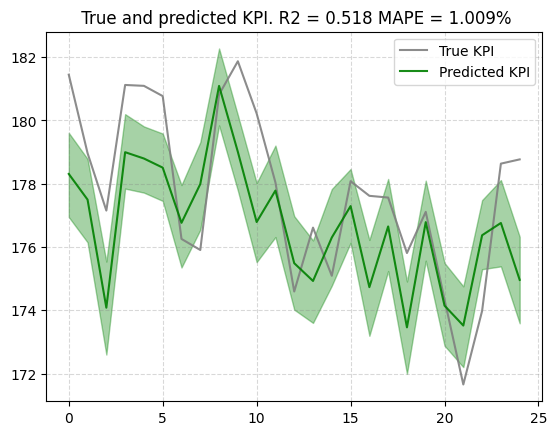

In [ ]:
plot_out_of_sample_model_fit(out_of_sample_predictions = prediction, out_of_sample_target = target_test)

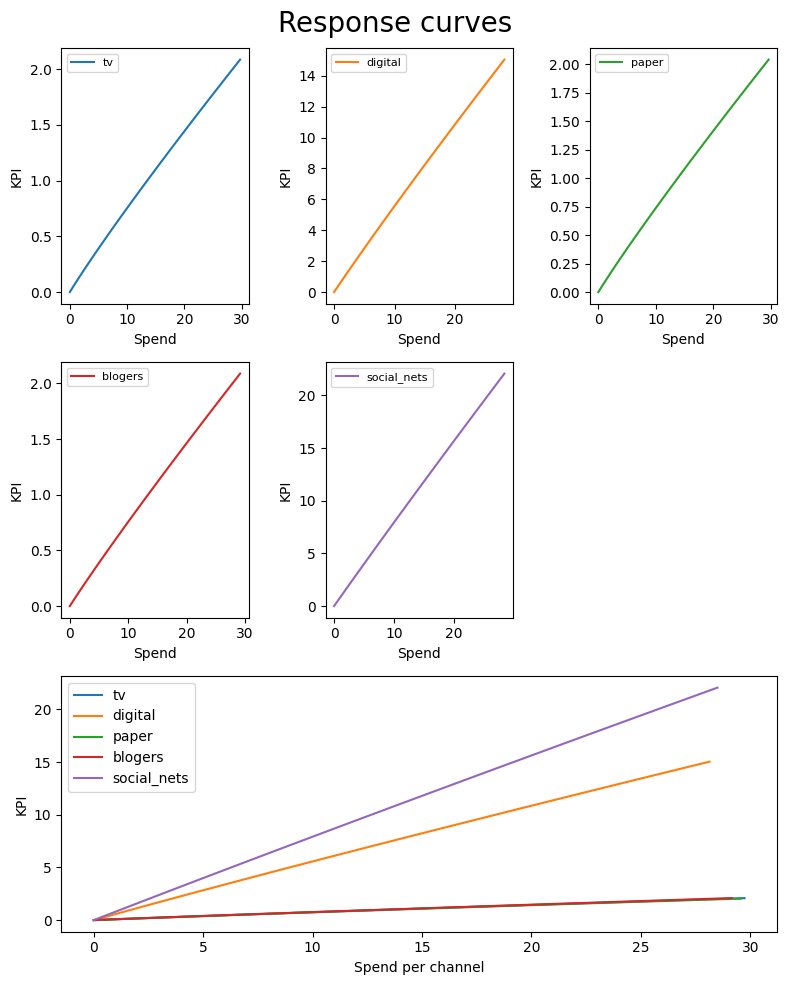

In [ ]:
plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)

## Форма не очень -- проблема синтетических данных (и выбранной модели тоже)    
В реальном мире кривые должны выполаживаться (насыщаться) или иметь S-образную форму (сначала быстрый рост, потом насыщение)

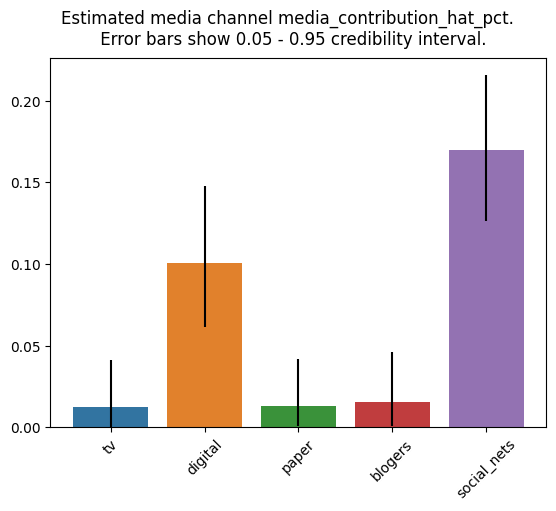

In [ ]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics(costs, cost_scaler = cost_scaler, target_scaler = target_scaler)
plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names, metric_name = 'media_contribution_hat_pct')
# media_contribution_hat_pct: The average media contribution percentage for each channel.

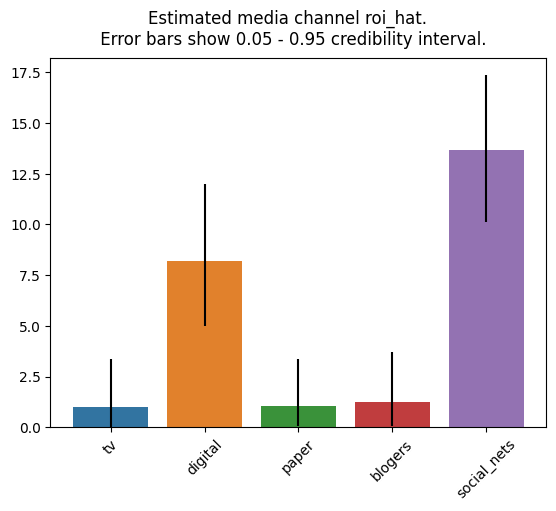

In [ ]:
plot_bars_media_metrics(metric=roi_hat, channel_names=media_names, metric_name = 'roi_hat')
# roi_hat: The return on investment of each channel calculated as its contribution divided by the cost.

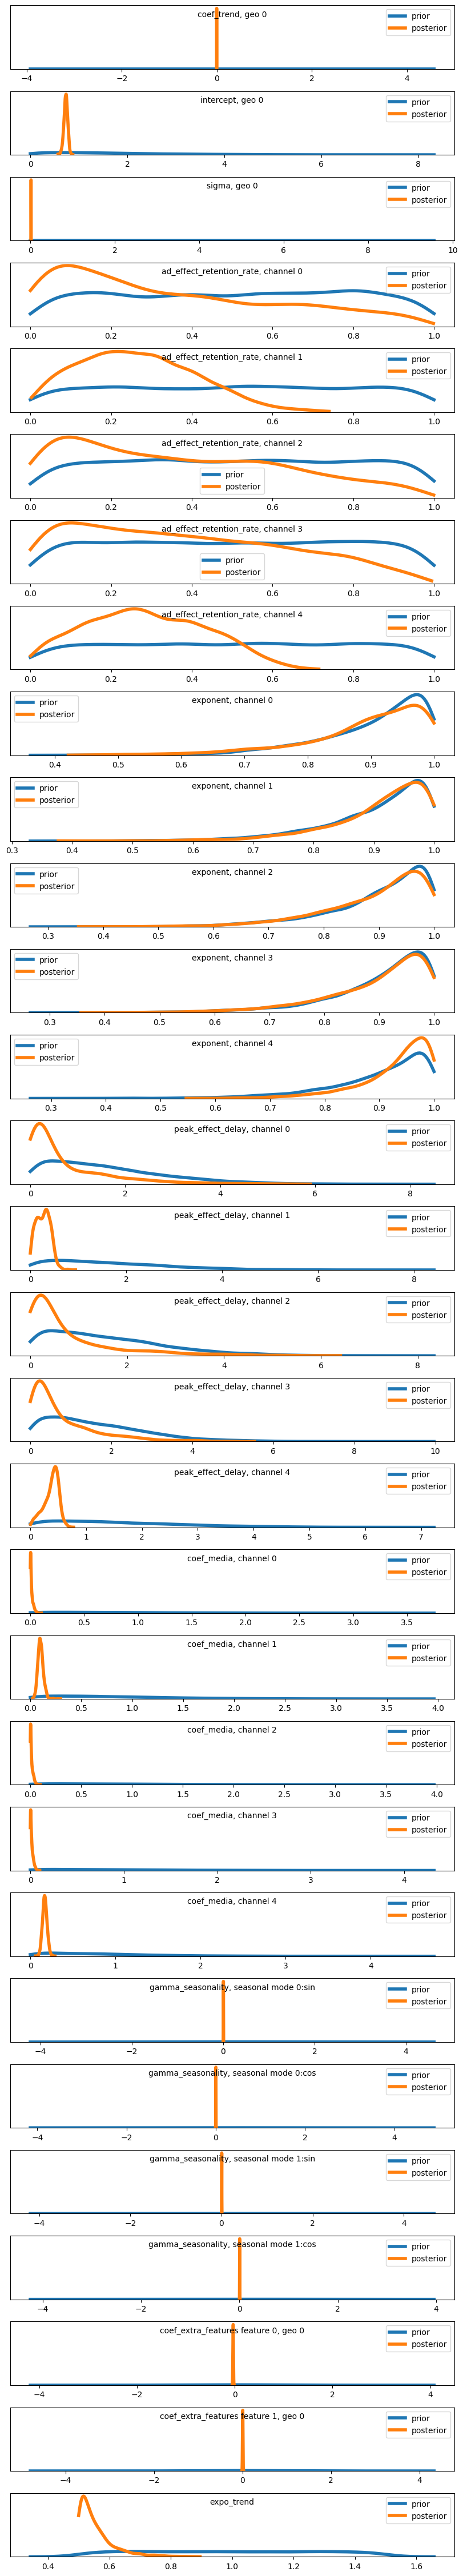

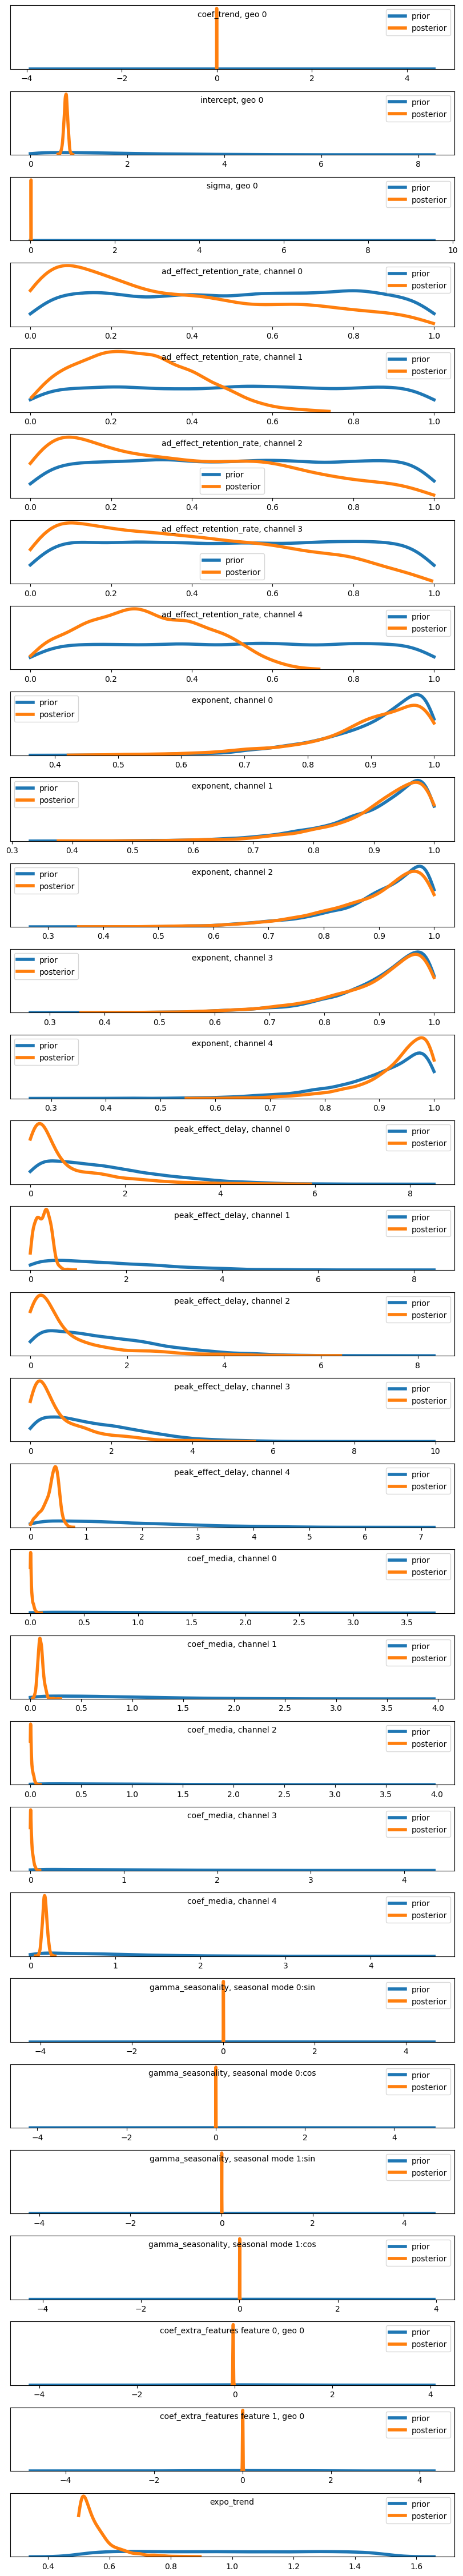

In [ ]:
plot_prior_and_posterior(media_mix_model=mmm)

## Оптимильная аллокация бюджета

In [ ]:
n_time_periods = len(target_test)
prices = jnp.ones(mmm.n_media_channels)
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
budget

Array(2502.0154, dtype=float32)

In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_test,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=123)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4625.147402619923
            Iterations: 21
            Function evaluations: 231
            Gradient evaluations: 21


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([400.79523, 595.4681 , 400.89856, 501.02106, 603.83246], dtype=float32)

In [ ]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([500.64856, 495.88123, 500.77762, 501.86127, 502.8467 ], dtype=float32)

In [ ]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(2502.0154, dtype=float32), Array(2502.0154, dtype=float32))

In [ ]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(2502.0154, dtype=float32), Array(2502.0154, dtype=float32))

In [ ]:
from lightweight_mmm.plot import plot_pre_post_budget_allocation_comparison

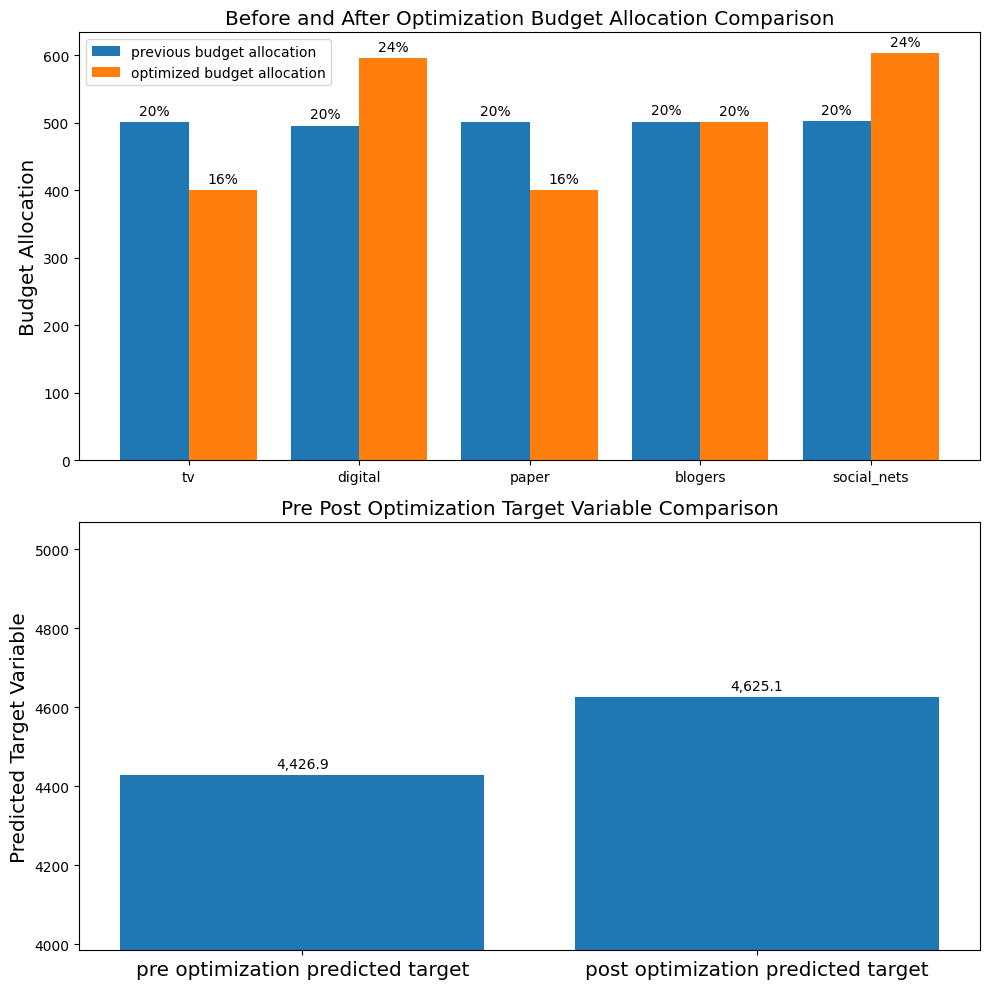

In [ ]:
plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))

In [ ]:
from lightweight_mmm.utils import save_model
from tabulate import tabulate
save_model(mmm, file_path='./mmm_eq.pkl')
all = []
for x, y, z in zip(media_names, solution.x, [float(x) for x in previous_media_allocation]):
  all.append([f'{x}',f'new {y:2.2f}', f'old {z:2.2f}'])
print(tabulate(all))

-----------  ----------  ----------
tv           new 400.80  old 500.65
digital      new 595.47  old 495.88
paper        new 400.90  old 500.78
blogers      new 501.02  old 501.86
social_nets  new 603.83  old 502.85
-----------  ----------  ----------


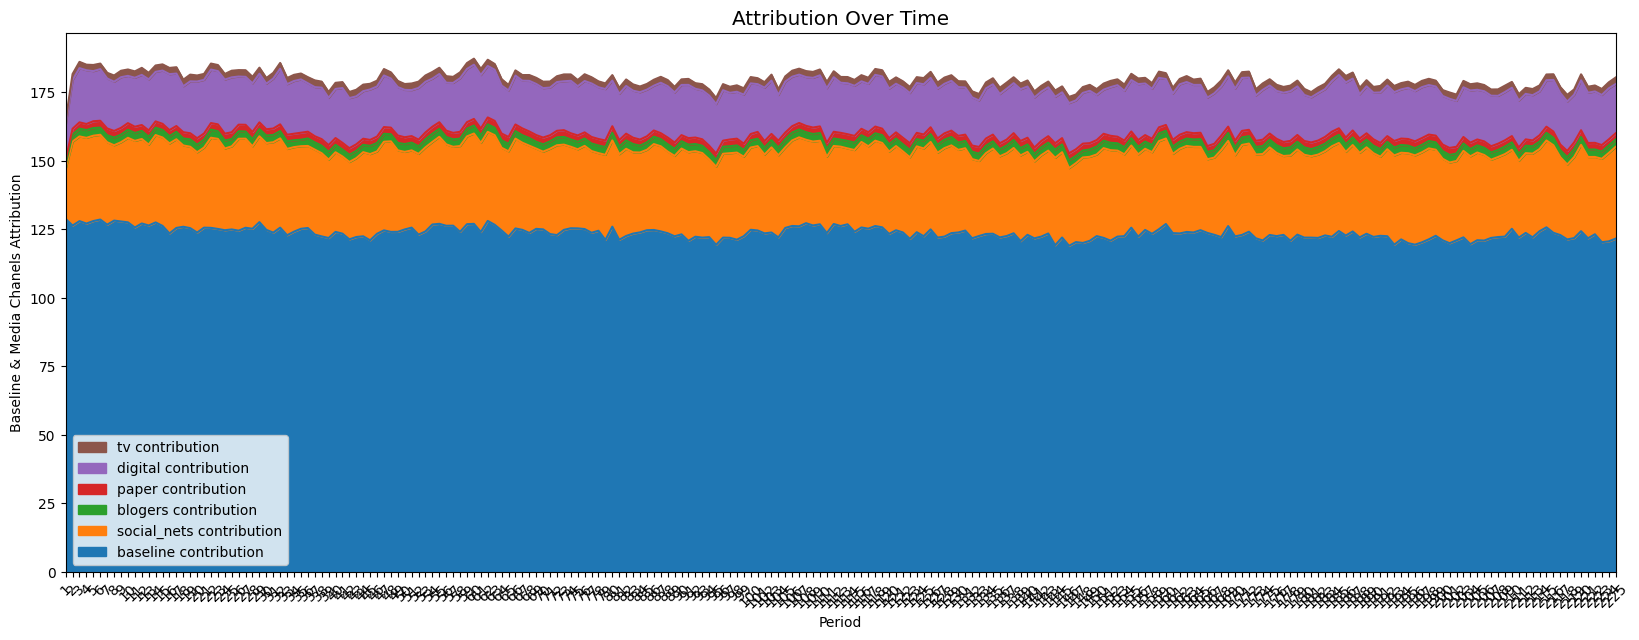

In [ ]:
from lightweight_mmm.plot import plot_media_baseline_contribution_area_plot
plot_media_baseline_contribution_area_plot(media_mix_model = mmm
                                           , target_scaler = target_scaler
                                           , channel_names = media_names)

# 2. Реальный (?) датасет

In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_requirements_lmmm.txt

--2025-03-14 18:56:55--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_requirements_lmmm.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139 [text/plain]
Saving to: ‘MMM_requirements_lmmm.txt.2’

MMM_requirements_lm 100%[===================>]     139  --.-KB/s    in 0s      

2025-03-14 18:56:55 (1.76 MB/s) - ‘MMM_requirements_lmmm.txt.2’ saved [139/139]



In [ ]:
!pip install -q -r MMM_requirements_lmmm.txt

In [ ]:
! wget https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_data.xlsx

--2025-03-14 18:57:14--  https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_data.xlsx
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_data.xlsx [following]
--2025-03-14 18:57:15--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395020 (386K) [application/octet-stream]
Saving to: ‘MMM_data.xlsx.1’

MMM_data.xlsx.1     100%[===================>] 385.76K  --.-KB/s    in 0.06s   

2025-03-14 18:57:15 (6.37 MB/s)

In [ ]:
import pandas as pd
real_data = pd.read_excel('MMM_data.xlsx')

In [ ]:
real_data

TV Manufacturing Brand       DATE  DEMAND   \
0     TV Manufacturing & Supplier Unit 2010-01-01     4384   
1     TV Manufacturing & Supplier Unit 2010-01-02     4366   
2     TV Manufacturing & Supplier Unit 2010-01-03     4006   
3     TV Manufacturing & Supplier Unit 2010-01-04     4076   
4     TV Manufacturing & Supplier Unit 2010-01-05     4834   
...                                ...        ...      ...   
2608  TV Manufacturing & Supplier Unit 2017-02-21     7312   
2609  TV Manufacturing & Supplier Unit 2017-02-22     6456   
2610  TV Manufacturing & Supplier Unit 2017-02-23     6060   
2611  TV Manufacturing & Supplier Unit 2017-02-24     5980   
2612  TV Manufacturing & Supplier Unit 2017-02-25     5609   

      Consumer Price Index (CPI)  Consumer Confidence Index(CCI)  \
0                          104.9                            96.3   
1                          104.9                            96.3   
2                          104.9                            96.3   
3                          104.9                            96.3   
4                          104.9                            96.3   
...                          ...                             ...   
2608                       101.4                           100.3   
2609                       101.4                           100.3   
2610                       101.4                           100.3   
2611                       101.4                           100.3   
2612                       101.4                           100.3   

      Producer Price Index (PPI)  Unit Price ($)  POS/ Supply Data  \
0                          106.7          361.62              4240   
1                          106.7          361.62              4266   
2                          106.7          361.62              4206   
3                          106.7          361.62              4176   
4                          106.7          361.62              5234   
...                          ...             ...               ...   
2608                       103.3          361.62              6974   
2609                       103.3          361.62              6123   
2610                       103.3          361.62              5989   
2611                       103.3          361.62              5877   
2612                       103.3          361.62              5467   

       SALES ($)  Advertising Expenses (SMS)  \
0     1533268.80                     77.4819   
1     1542670.92                     73.4783   
2     1520973.72                     80.6093   
3     1510125.12                     65.9319   
4     1892719.08                     77.4819   
...          ...                         ...   
2608  2521937.88                     60.6667   
2609  2214199.26                     59.1026   
2610  2165742.18                     61.1351   
2611  2125240.74                     53.7865   
2612  1976976.54                     71.5344   

      Advertising Expenses(Newspaper ads)  Advertising Expenses(Radio)  \
0                               14.104193                     112.3370   
1                               13.298758                     105.7133   
2                               13.200691                     108.7702   
3                               12.721429                      93.3065   
4                               14.104193                     112.3370   
...                                   ...                          ...   
2608                            13.488857                      76.7250   
2609                            13.206593                      78.6058   
2610                            12.775135                      76.2872   
2611                            12.940132                      74.9424   
2612                            13.742857                      90.9226   

      Advertising Expenses(TV)  Advertising Expenses(Internet)  \
0                    1479.4565                         722.571   
1              

In [ ]:
for col in real_data.columns:
  print(col)

TV Manufacturing Brand
DATE
DEMAND 
Consumer Price Index (CPI)
Consumer Confidence Index(CCI)
Producer Price Index (PPI)
Unit Price ($)
POS/ Supply Data
SALES ($)
Advertising Expenses (SMS)
Advertising Expenses(Newspaper ads)
Advertising Expenses(Radio)
Advertising Expenses(TV)
Advertising Expenses(Internet)
GRP (NewPaper ads)
GRP(SMS)
GRP(Radio
GRP(Internet)
GRP(TV)


*   TV Manufacturing Brand - какое название юнита
*   DATE - дата
*   DEMAND - спрос на товар
*   Consumer Price Index (CPI) - индекс роста потребительских цен
*   Consumer Confidence Index(CCI) - индекс уверенности потребителя в *   стабильности экономики. По сути это индекс инфляционных настроений
*   Producer Price Index (PPI) - индекс цен производителя
*   Unit Price (\$) - цена\ за\ юнит
*   POS/ Supply Data - объемы доступных товаров для продажи в точках по идее
*   SALES ($) - выручка с фактически проданных товаров
*   Advertising Expenses (SMS) - затраты на канал СМС
*   Advertising Expenses(Newspaper ads) - затраты на газеты и журналы
*   Advertising Expenses(Radio) - затраты на Радио рекламу
*   Advertising Expenses(TV) - затраты на ТВ рекламу
*   Advertising Expenses(Internet) - затраты на Диджитал рекламу
*   GRP (NewPaper ads) - Gross Rating Points, рейтинги показов рекламы в газетах и журналах (доля покрытой аудитории * частоту просмотров, от всей аудитории страны/региона. Считаем, что это *   некая относительная метрика охвата аудитории)
*   GRP(SMS) - то же самое для СМС
*   GRP(Radio - для Радио
*   GRP(Internet) - для Диджитала (странно, что тут GRP, потому что в диджитале объемы меряют показами. Наверное, тут что-то типа доли Охваченной аудитории)
*   GRP(TV)  - то же самое для ТВ

In [ ]:
import os
import sys
import warnings
import pickle

import numpy as np
import pandas as pd
import scipy
import optuna

from lightweight_mmm.utils import simulate_dummy_data
from lightweight_mmm.preprocessing import CustomScaler
from lightweight_mmm.lightweight_mmm import LightweightMMM
import jax.numpy as jnp
from numpyro import distributions, set_host_device_count
from lightweight_mmm.plot import plot_model_fit, plot_media_channel_posteriors, plot_response_curves, plot_bars_media_metrics, plot_out_of_sample_model_fit, plot_prior_and_posterior, plot_pre_post_budget_allocation_comparison, plot_media_baseline_contribution_area_plot
from lightweight_mmm.optimize_media import find_optimal_budgets

from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_percentage_error as mape
from optuna import Trial


import optuna
from optuna.trial import TrialState

warnings.filterwarnings('ignore')
set_host_device_count(2)

In [ ]:
real_media_data = np.array(real_data[['GRP(SMS)', 'GRP (NewPaper ads)', 'GRP(Radio', 'GRP(Internet)', 'GRP(TV)']])
# не используем денежные -- инфляция бывает очень сильной
real_target = np.array(real_data['SALES ($)'])
real_extra_features = np.array(real_data[['DEMAND ', 'Consumer Price Index (CPI)', 'Consumer Confidence Index(CCI)', 'Producer Price Index (PPI)', 'Unit Price ($)']])
real_media_data

real_data_size = len(real_target)
real_media_names = ['SMS', 'Newspaper ads', 'Radio', 'Internet', 'TV']

sms_cost = real_data['Advertising Expenses (SMS)'].sum()
news_cost = real_data['Advertising Expenses(Newspaper ads)'].sum()
radio_cost = real_data['Advertising Expenses(Radio)'].sum()
internet_cost = real_data['Advertising Expenses(Internet)'].sum()
tv_cost = real_data['Advertising Expenses(TV)'].sum()


### А как считать цены, если метрики по каждому каналу разные?

In [ ]:
def preprocess_data(scaler_type = 'std'):

    scaler_type = getattr(jnp, scaler_type)

    global real_media_scaler, real_extra_features_scaler, real_target_scaler, real_cost_scaler, real_media_prior

    real_media_scaler = CustomScaler(divide_operation=scaler_type)
    real_extra_features_scaler = CustomScaler(divide_operation=scaler_type)
    real_target_scaler = CustomScaler(divide_operation=scaler_type)

    real_cost_scaler = CustomScaler(divide_operation=scaler_type)

    real_media_prior = np.array([sms_cost, news_cost, radio_cost, internet_cost, tv_cost]) * real_data_size

    real_split_point = real_data_size - real_data_size // 10

    real_media_data_train = real_media_data[:real_split_point, :]
    real_target_train = real_target[:real_split_point]
    real_extra_features_train = real_extra_features[:real_split_point, :]

    real_extra_features_test = real_extra_features[real_split_point:, :]
    real_target_test = real_target[real_split_point:]
    real_media_data_test = real_media_data[real_split_point:, :]

    real_media_data_train = real_media_scaler.fit_transform(real_media_data_train)
    real_extra_features_train = real_extra_features_scaler.fit_transform(real_extra_features_train)
    real_target_train = real_target_scaler.fit_transform(real_target_train)
    real_costs_scaled = real_cost_scaler.fit_transform(real_media_prior)

    real_media_data_test = real_media_scaler.transform(real_media_data_test)
    target_test = real_target_scaler.transform(real_target_test)
    real_extra_features_test = real_extra_features_scaler.transform(real_extra_features_test)

    return real_media_data_train, real_extra_features_train, real_target_train, \
real_media_data_test, real_extra_features_test, target_test, real_costs_scaled

In [ ]:
real_media_data_train, real_extra_features_train, real_target_train, \
real_media_data_test, real_extra_features_test, target_test, real_costs_scaled = preprocess_data()

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 399, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

### Гиперпараметры модели (подробно можно почитать [здесь](https://lightweight-mmm.readthedocs.io/en/latest/models.html))

### В LMMM основными гиперпараметрами модели являются:
    - Количество сезонных компонент
    - Частнотность по времени
    - Prior распределения для:
        - media - каналов
        - структурных переменных (other)
        - тренда
        - сезонности
        - intercept'а
        - параметров adstock преобразований
        
   [Подробнее о том, как настраивать priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/)

### Подберем priors для каждого параметра:

In [ ]:
def objective(trial):

    """
    Prior для intercept
    """
    intercept = trial.suggest_float("intercept", 0.2, 4)

    """
    Prior для коэффициента тренда
    """
    coef_trend_mu = trial.suggest_float("coef_trend_mu", 0.1, 3)
    coef_trend_sigma = trial.suggest_float("coef_trend_sigma", 0.5, 1)

    """
    Prior для степенного показателя тренда
    """
    expo_trend_x_0 = trial.suggest_float("expo_trend_x_0", 0.5, 0.8)
    expo_trend_x_1 = trial.suggest_float("expo_trend_x_1", 0.8, 1.7)

    """
    Prior для распределения сезонности
    """
    weekday_mu = trial.suggest_float("weekday_mu", 0, 5)
    weekday_sigma = trial.suggest_float("weekday_sigma", 0.1, 2)

    degrees_seasonality = trial.suggest_int("degrees_seasonality", 1, 3)
    seasonality_frequencies = trial.suggest_int("seasonality_frequencies", 52, 365)

    """
    Prior для распределения extra-переменных
    """
    coef_extra_features_mu = trial.suggest_float("coef_extra_features", -10, 10)
    coef_extra_features_sigma = trial.suggest_float("coef_extra_features_sigma", 0.3, 1)

    """
    Prior для распределения параметра k в Hill equation (точка перегиба)
    """
    hills_k_alpha = trial.suggest_float("hills_k_alpha", 0.1, 10)
    hills_k_beta = trial.suggest_float("hills_k_beta", 0.1, 10)

    """
    Prior для распределения параметра s в Hill equation ("скорость" насыщения)
    """
    slope_alpha = trial.suggest_float("slope_alpha", 0.1, 10)
    slope_beta = trial.suggest_float("slope_beta", 0.1, 10)

    """
    Параметры MCMC-сэмплирования
    """
    number_warmup = trial.suggest_int("number_warmup", 800, 1200)
    number_samples = trial.suggest_int("number_samples", 800, 1200)
    number_chains = trial.suggest_int("number_chains", 1, 3)




    custom_priors = {"intercept" : distributions.HalfNormal(scale = intercept),
                     "coef_trend" : distributions.Normal(loc = coef_trend_mu, scale = coef_trend_sigma),
                     "expo_trend" : distributions.Uniform(low = expo_trend_x_0, high = expo_trend_x_1),
                     "weekday" : distributions.Normal(loc = weekday_mu, scale = weekday_sigma),
                     "coef_extra_features" : distributions.Normal(loc = coef_extra_features_mu, scale = coef_extra_features_sigma),
                     "half_max_effective_concentration" : distributions.Gamma(concentration = hills_k_alpha, rate = hills_k_beta),
                     "slope" : distributions.Gamma(concentration = slope_alpha, rate = slope_beta)}


    model = LightweightMMM(model_name = 'hill_adstock')

    model.fit(media=real_media_data_train,
        media_names=real_media_names,
        extra_features=real_extra_features_train,
        media_prior=real_costs_scaled,
        target=real_target_train,
        weekday_seasonality = True,
        degrees_seasonality = degrees_seasonality,
        seasonality_frequency = seasonality_frequencies,
        number_warmup = number_warmup,
        number_samples = number_samples,
        number_chains = number_chains,
        custom_priors = custom_priors,
        seed = 42)


    real_prediction = model.predict(
    media=real_media_data_test,
    extra_features=real_extra_features_test
    )

    test_mape = mape(real_target_test, real_prediction.mean(axis = 0))
    return test_mape

Следующая ячейка долгая, если не хотите ждать -- ниже подгрузим подобранные параметры модели

In [ ]:
if __name__ == "__main__":
    sampler = optuna.samplers.RandomSampler(seed = 42)
    study = optuna.create_study(sampler = sampler, direction="minimize")
    study.optimize(objective, n_trials=1000, timeout=36000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")

    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    with open('MMM_Optimal_lmmm_config.pkl', 'wb') as file:
        pickle.dump(trial.params.items(), file, protocol=pickle.HIGHEST_PROTOCOL)

[I 2025-03-14 18:52:55,533] A new study created in memory with name: no-name-02f2c24b-b7e6-4fbd-8a39-399541fef86f


  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

In [ ]:
!wget https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_Optimal_Lmmm_config_current.pkl

--2025-03-14 18:58:35--  https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_Optimal_Lmmm_config_current.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Optimal_Lmmm_config_current.pkl [following]
--2025-03-14 18:58:36--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Optimal_Lmmm_config_current.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 842 [application/octet-stream]
Saving to: ‘MMM_Optimal_Lmmm_config_current.pkl’

MMM_Optimal_Lmmm_co 100%[===========

In [ ]:
with open('MMM_Optimal_Lmmm_config_current.pkl', 'rb') as file:
   model_pretrained_config = pickle.load(file)

## Небыстрый фит

In [ ]:
real_mmm_ = LightweightMMM(model_name = 'hill_adstock') # carryover, adstock, hill_adstock
real_mmm_.fit(media=real_media_data_train,
    media_names=real_media_names,
    extra_features=real_extra_features_train,
    media_prior=real_costs_scaled,
    target=real_target_train,
    **model_pretrained_config,
    seed = 42)

sample: 100%|██████████| 3200/3200 [46:07<00:00,  1.16it/s, 1023 steps of size 1.28e-03. acc. prob=0.93]


In [ ]:
real_mmm_.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.83      0.01      0.84      0.81      0.86     96.20      1.00
             coef_extra_features[1]     -0.15      0.01     -0.15     -0.17     -0.13    100.25      1.04
             coef_extra_features[2]     -0.06      0.01     -0.06     -0.07     -0.04    270.19      1.00
             coef_extra_features[3]     -0.05      0.01     -0.05     -0.07     -0.03     99.70      1.00
             coef_extra_features[4]      0.09      0.01      0.09      0.07      0.10    120.65      1.00
                      coef_media[0]      0.02      0.02      0.01      0.00      0.05    157.49      1.00
                      coef_media[1]      0.01      0.01      0.01      0.00      0.01    171.25      1.00
                      coef_media[2]      0.05      0.04      0.03      0.00      0.11    157.60      1.00
                      coef_media[3]     11.23

In [ ]:
from lightweight_mmm import utils

In [ ]:
utils.save_model(real_mmm_, file_path = 'collab_testing_model')

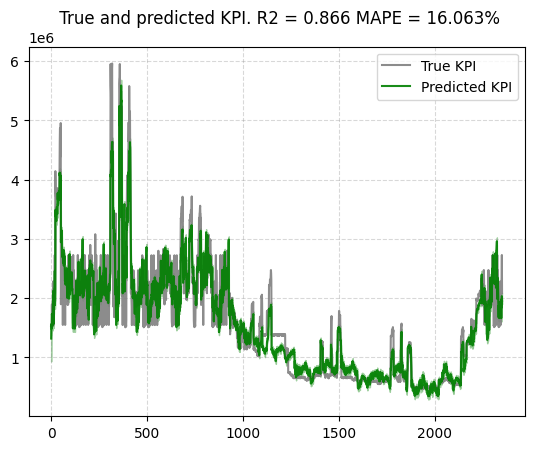

In [ ]:
plot_model_fit(media_mix_model=real_mmm_, target_scaler=real_target_scaler)

In [ ]:
real_prediction = real_mmm_.predict(
media=real_media_data_test,
extra_features=real_extra_features_test
)

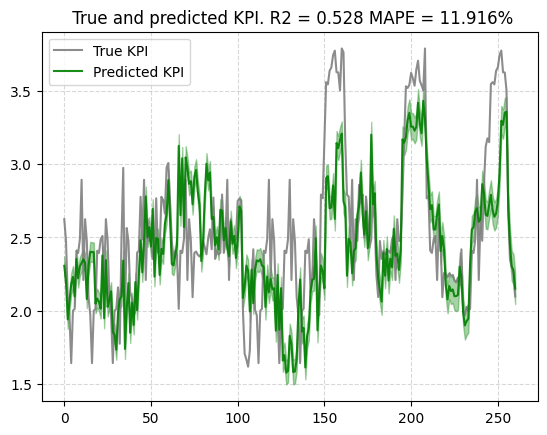

In [ ]:
plot_out_of_sample_model_fit(out_of_sample_predictions = real_prediction
                             , out_of_sample_target = target_test)

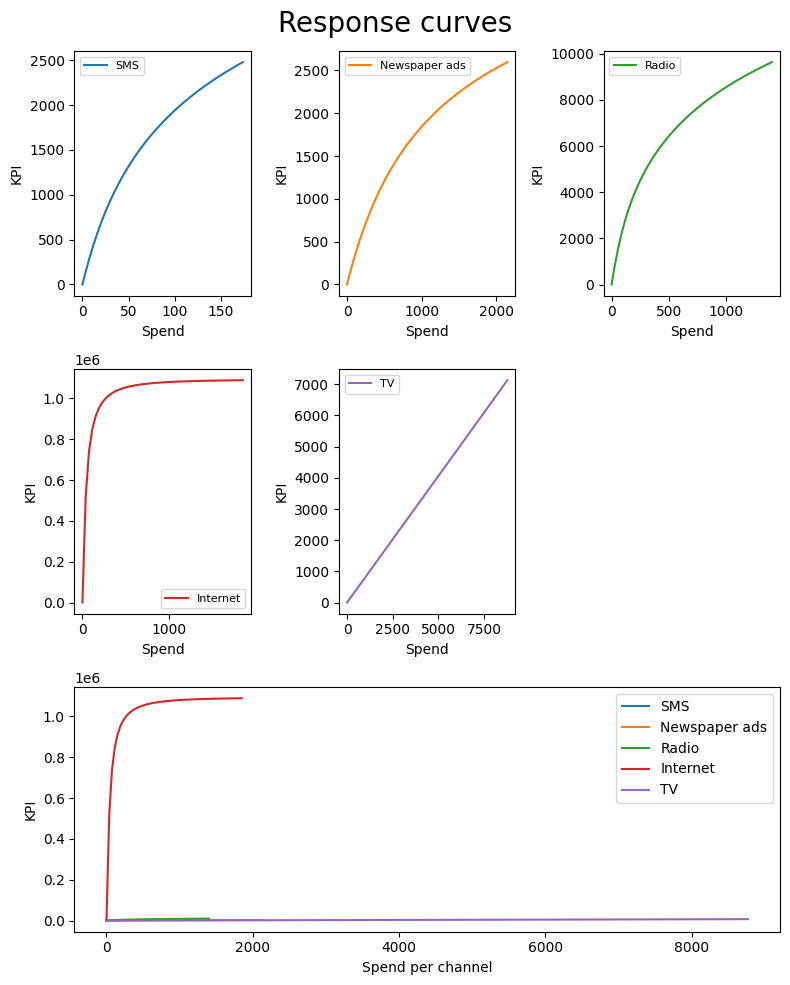

In [ ]:
plot_response_curves(media_mix_model=real_mmm_, media_scaler=real_media_scaler, target_scaler=real_target_scaler)

уже лучше, но тоже клиенту не покажешь
[пример когда все сошлось](https://github.com/slavakx/medium_posts/blob/master/budget_optimization_mmm/budget_optimization_mmm_article.ipynb)

In [ ]:
real_media_effect_hat, real_roi_hat = real_mmm_.get_posterior_metrics(real_media_prior # подадим реальный кост
                                                                     , cost_scaler = real_cost_scaler
                                                                     , target_scaler = real_target_scaler)

# media_contribution_hat_pct: The average media contribution percentage for each channel.

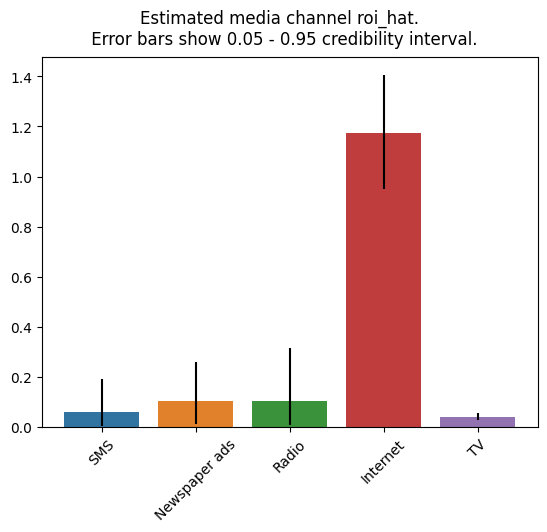

In [ ]:
plot_bars_media_metrics(metric=real_roi_hat, channel_names=real_media_names, metric_name = 'roi_hat')
# roi_hat: The return on investment of each channel calculated as its contribution divided by the cost.

In [ ]:
#plot_prior_and_posterior(media_mix_model=real_mmm)

## Оптимильная аллокация бюджета

In [ ]:
sms_price = real_data['Advertising Expenses (SMS)'].sum() / real_data['GRP(SMS)'].sum()
news_price = real_data['Advertising Expenses(Newspaper ads)'].sum() / real_data['GRP (NewPaper ads)'].sum()
radio_price = real_data['Advertising Expenses(Radio)'].sum() / real_data['GRP(Radio'].sum()
internet_price = real_data['Advertising Expenses(Internet)'].sum() / real_data['GRP(Internet)'].sum()
tv_price = real_data['Advertising Expenses(TV)'].sum() / real_data['GRP(TV)'].sum()

real_media_prices = np.array([sms_price, news_price, radio_price, internet_price, tv_price])

In [ ]:
real_n_time_periods = len(target_test)
real_prices = real_media_prices
real_budget = jnp.sum(jnp.dot(real_prices, real_media_data.mean(axis=0))) * real_n_time_periods

real_budget

Array(1191412.8, dtype=float32)

In [ ]:
# Run optimization with the parameters of choice.
real_solution, real_kpi_without_optim, real_previous_media_allocation = find_optimal_budgets(
    n_time_periods=real_n_time_periods,
    media_mix_model=real_mmm_,
    extra_features=real_extra_features_test,
    budget=real_budget,
    prices=real_prices,
    media_scaler=real_media_scaler,
    target_scaler=real_target_scaler,
    seed=123)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -608002181.07003
            Iterations: 31
            Function evaluations: 330
            Gradient evaluations: 30


In [ ]:
# Obtain the optimal weekly allocation.
real_optimal_buget_allocation = real_prices * real_solution.x
real_optimal_buget_allocation

array([ 15331.67414644,   3973.61879742,  27697.75617783, 728930.53001788,
       415479.17086044])

In [ ]:
# similar renormalization to get previous budget allocation
real_previous_budget_allocation = real_prices * real_previous_media_allocation
real_previous_budget_allocation

Array([ 15765.727 ,   3303.1392,  23024.236 , 803945.4   , 345374.25  ],      dtype=float32)

In [ ]:
# Both these values should be very close in order to compare KPI
real_budget, real_optimal_buget_allocation.sum()

(Array(1191412.8, dtype=float32), 1191412.7499999998)

In [ ]:
# Both numbers should be almost equal
real_budget, jnp.sum(real_solution.x * real_prices)

(Array(1191412.8, dtype=float32), Array(1191412.8, dtype=float32))

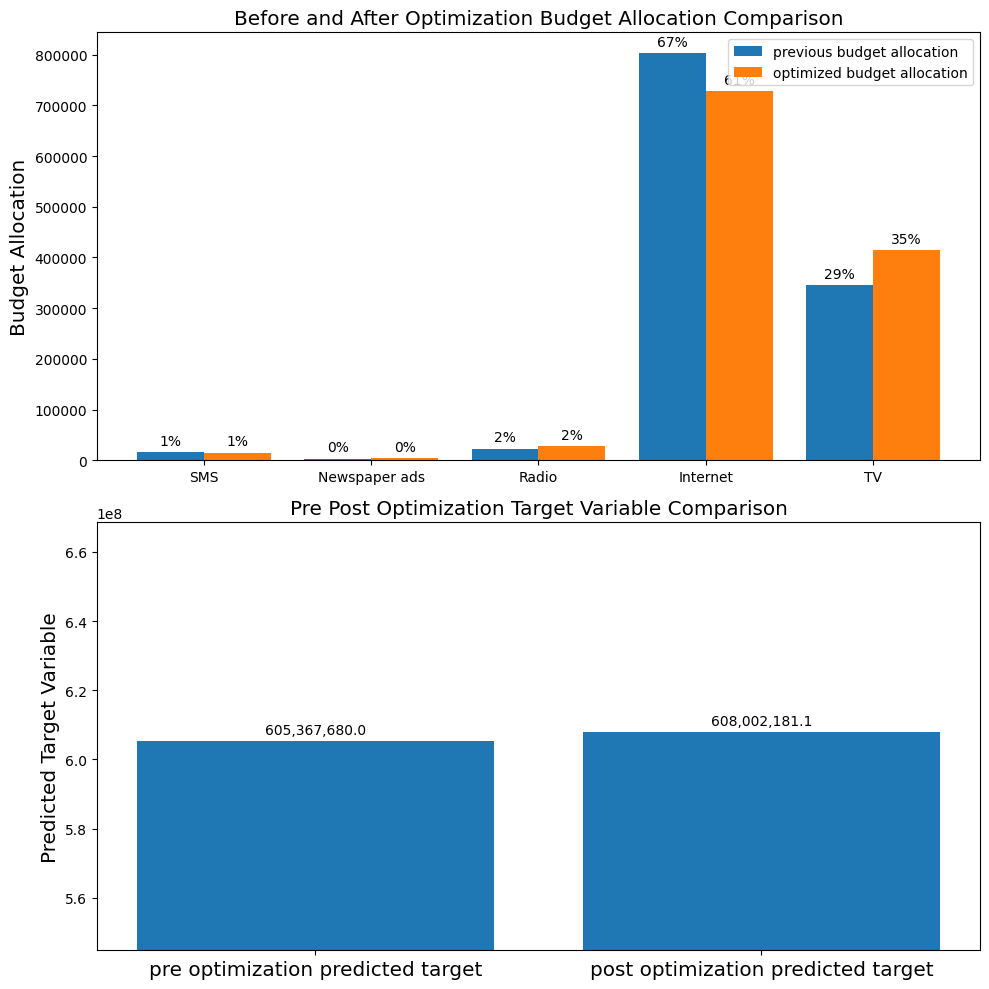

In [ ]:
plot_pre_post_budget_allocation_comparison(media_mix_model=real_mmm_,
                                                kpi_with_optim=real_solution['fun'],
                                                kpi_without_optim=real_kpi_without_optim,
                                                optimal_buget_allocation=real_optimal_buget_allocation,
                                                previous_budget_allocation=real_previous_budget_allocation,
                                                figure_size=(10,10))

In [ ]:
from lightweight_mmm.utils import save_model

In [ ]:
save_model(real_mmm_, file_path='./MMM_evaluated_model.pkl')
real_all = []
for x, y, z in zip(real_media_names, real_solution.x, [float(x) for x in np.array(real_previous_media_allocation)]):
  real_all.append([f'{x}',f'new {y:2.2f}', f'old {z:2.2f}'])
print(real_all)

[['SMS', 'new 7773.47', 'old 7993.55'], ['Newspaper ads', 'new 158709.09', 'old 131929.68'], ['Radio', 'new 43850.30', 'old 36451.31'], ['Internet', 'new 67758.47', 'old 74731.56'], ['TV', 'new 359521.34', 'old 298858.33']]


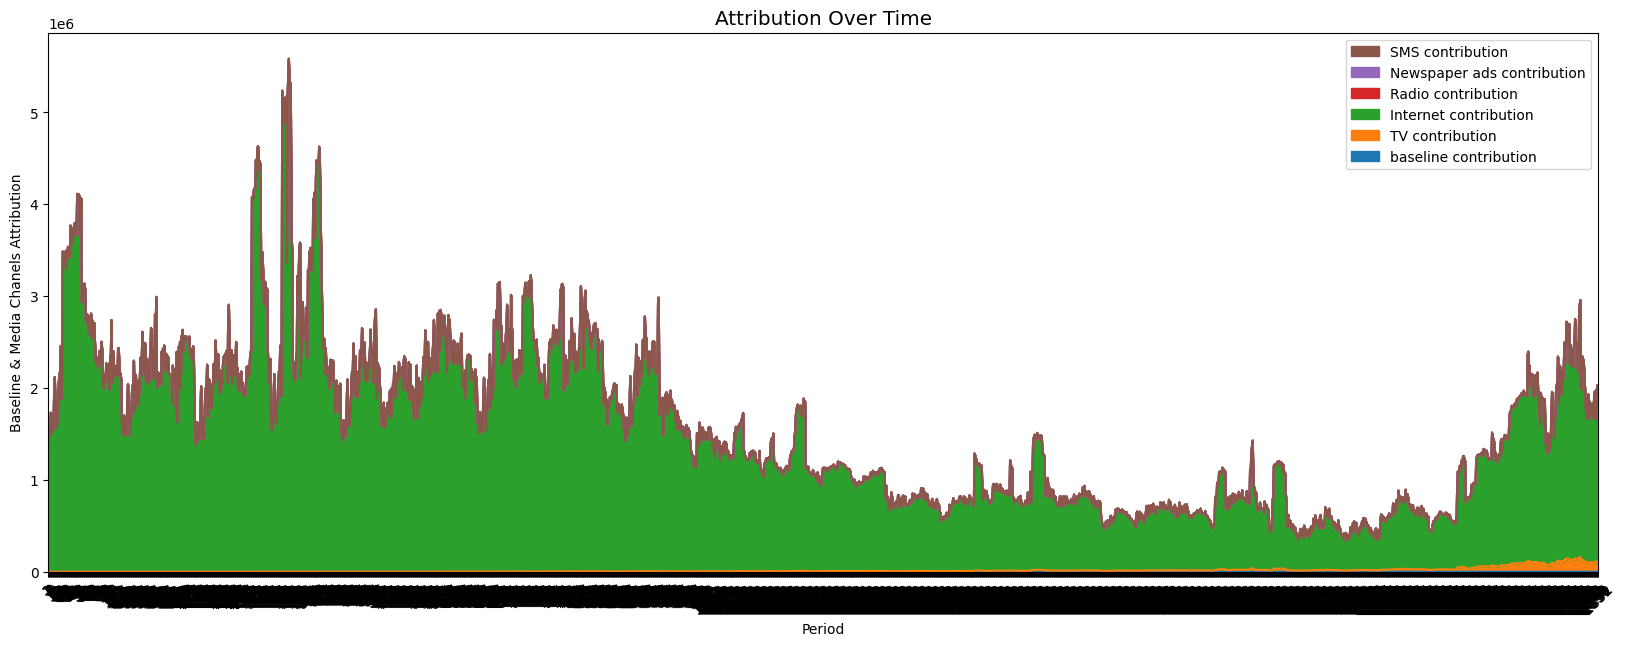

In [ ]:
plot_media_baseline_contribution_area_plot(media_mix_model = real_mmm_
                                           , target_scaler = real_target_scaler
                                           , channel_names = real_media_names)

# 3. Meridian

Здесь уже точно пора на среду с GPU переключиться

Для любителей -- оригинальный туториал

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_meridian_requirements_upd.txt

--2025-03-17 12:50:58--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_requirements_meridian_upd.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-17 12:50:58 ERROR 404: Not Found.



In [ ]:
!pip uninstall -y -q dopamine-rl torch orbax-checkpoint fastai flax sentence-transformers tensorflow-text

In [ ]:
!pip install -q -r MMM_meridian_requirements_upd.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.9 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement pickle==4.0 (from versions: none)
ERROR: No matching distribution found for pickle==4.0


In [ ]:
!pip install google-meridian[colab,and-cuda]==1.0.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import pickle

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

import warnings
warnings.filterwarnings('ignore')

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


Настройка map'инга для загрузки данных

### Data collection
    - Media-переменные - гранулярность по временным периодам, только неотрицательные значения
    - Media spend - спенды по каждому из медиа-каналов, размерность = размерности медиа-переменных
    - Control variables - переменные, которые аффектят и KPI, и медиа-метрики. Настройка необходима для корректного моделирования каузальных эффектов на основе графа взаимозависимости фич. Подробнее о построении последнего: https://developers.google.com/meridian/docs/basics/causal-graph
    - KPI
    - Revenue per KPI
    - Geo population

### Расширение переменных:
    - органика - медиа-переменные, не имеющие прямых затрат
    - non-media-treatments - структурные переменные продукта: промо, изменение цены, etc.

Подробнее о сборе данных - https://developers.google.com/meridian/docs/user-guide/collect-data

Из документации Meridian:

Best Practice: Collect data at the weekly level. Weekly data presents an advantageous equilibrium between the degree of variation and the extent of noise, particularly when compared to daily or monthly data.

In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Real_MMM_Meridian.csv

--2025-03-17 12:56:29--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Real_MMM_Meridian.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534290 (522K) [text/plain]
Saving to: ‘MMM_Real_MMM_Meridian.csv’

MMM_Real_MMM_Meridi 100%[===================>] 521.77K  --.-KB/s    in 0.03s   

2025-03-17 12:56:30 (18.6 MB/s) - ‘MMM_Real_MMM_Meridian.csv’ saved [534290/534290]



In [ ]:
coord_to_columns = load.CoordToColumns(
    time='DATE',
    controls=[],
    population='population',
    kpi='SALES ($)',
    #revenue_per_kpi='revenue_per_conversion',
    media=['GRP(SMS)', 'GRP(Internet)', 'GRP(TV)', 'GRP (NewPaper ads)', 'GRP(Radio'],
    media_spend=['Advertising Expenses (SMS)', 'Advertising Expenses(Internet)', 'Advertising Expenses(TV)',
                 'Advertising Expenses(Newspaper ads)', 'Advertising Expenses(Radio)'],
    non_media_treatments=['DEMAND ', 'Consumer Price Index (CPI)', 'Consumer Confidence Index(CCI)', 'Producer Price Index (PPI)', 'Unit Price ($)'],
)

In [ ]:
correct_media_to_channel = {
    'GRP(SMS)': 'SMS',
    'GRP(Internet)': 'Internet',
    'GRP(TV)': 'TV',
    'GRP (NewPaper ads)': 'NewPaper ads',
    'GRP(Radio': 'Radio',
}
correct_media_spend_to_channel = {
    'Advertising Expenses (SMS)': 'SMS',
    'Advertising Expenses(Internet)': 'Internet',
    'Advertising Expenses(TV)': 'TV',
    'Advertising Expenses(Newspaper ads)': 'NewPaper ads',
    'Advertising Expenses(Radio)': 'Radio',
}

In [ ]:
loader = load.CsvDataLoader(
    csv_path="MMM_Real_MMM_Meridian.csv",
    kpi_type='non_revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel
)
data = loader.load()
n_timestamps = vars(data)['kpi'].shape[1]

Настройка модели. Спецификации модели (требует знания бизнес-метрик продукта)

1.   priors - priors для adstock, ROI, etc.
2.   media_effects_dist - prior для media параметров
3.   hill_before_adstock - очередность adstock и diminishing returns
4.   unique_sigma_for_each_geo - уникальная дисперсия для каждого гео
5.   paid_media_prior_type - параметр калибровки ROI
6.   knots - маска для настройки [сезонности](https://developers.google.com/meridian/docs/advanced-modeling/setting-knots#how-knots-argument-works)
7.   baseline_geo - is treated as the reference geo in the dummy encoding of geos
8. control_population_scaling_id - параметр скейлинга контролируемых медиа-каналов на население

О методах настройки параметров модели можно прочитать [здесь](https://developers.google.com/meridian/docs/user-guide/configure-model#tune-roi-calibration)

In [ ]:
! wget https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_Meridian_optimal_config.pkl

--2025-03-17 12:57:42--  https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_Meridian_optimal_config.pkl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Meridian_optimal_config.pkl [following]
--2025-03-17 12:57:42--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_Meridian_optimal_config.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1972 (1.9K) [application/octet-stream]
Saving to: ‘MMM_Meridian_optimal_config.pkl’

MMM_Meridian_optima 100%[===================

In [ ]:
#Загрузка оптимальной модели

with open('MMM_Meridian_optimal_config.pkl', 'rb') as file:
  optimal_model_config = pickle.load(file)

prior = prior_distribution.PriorDistribution(**optimal_model_config['prior'])
optimal_model_config.pop('prior')

#Маска для OOT-наблюдений
holdout_ids = np.full(n_timestamps, False)
holdout_ids[-n_timestamps//10: ] = True


model_spec = spec.ModelSpec(**optimal_model_config, prior = prior, holdout_id = holdout_ids)

mmm = model.Meridian(input_data = data, model_spec = model_spec)

Сэмплим prior и posterior распределения для параметров на основе MCMC

In [ ]:
! wget https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_optimal_mcmc_setup.pkl

--2025-03-17 12:57:50--  https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/MMM_optimal_mcmc_setup.pkl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_optimal_mcmc_setup.pkl [following]
--2025-03-17 12:57:50--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/MMM_optimal_mcmc_setup.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87 [application/octet-stream]
Saving to: ‘MMM_optimal_mcmc_setup.pkl’

MMM_optimal_mcmc_se 100%[===================>]      87  --.-KB/s    in 0s

In [ ]:
with open('MMM_optimal_mcmc_setup.pkl', 'rb') as file:
  optimal_mcmc_setup = pickle.load(file)

prior_samples = optimal_mcmc_setup['prior_samples']
optimal_mcmc_setup.pop('prior_samples')

500

Следующая ячейка минут на 10-15

In [ ]:
%%time
mmm.sample_prior(prior_samples)
mmm.sample_posterior(**optimal_mcmc_setup)

CPU times: user 8min 33s, sys: 15.5 s, total: 8min 48s
Wall time: 8min 41s


Оценка сходимости модели. Для оценки сходимости MCMC используется R̂ статистика. Подробнее прочитать про методы оценки можно [здесь](https://avehtari.github.io/masterclass/slides_rhat_neff.pdf) Сходимость достигается при R̂ ~ 1.0, из документации Meridian R̂ < 1.2 считается приближенной сходимостью и может быть использован как трэшхолд

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

Обучаем модель

In [ ]:
model_fit = visualizer.ModelFit(mmm)

Meridian поддерживает генерацию интерпретируемых результатов в HTML формате. Для этого:

In [ ]:
mmm_summarizer = summarizer.Summarizer(mmm)
filepath = '/content/drive/MyDrive'
start_date = '2010-01-01'
end_date = '2017-02-25'
mmm_summarizer.output_model_results_summary('summary_output_real_data.html', filepath, start_date, end_date)

In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/summary_output_real_data.html')

<a name="generate-optimize"></a>
## Оптимальная аллокация бюджетов: доступен выбор стратегии аллокации бюджетов, дефолтно  - максимацизация по ROI

In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(use_kpi=True)

CPU times: user 34.3 s, sys: 1.45 s, total: 35.7 s
Wall time: 35.8 s


In [ ]:
optimization_results.optimized_data

<xarray.Dataset> Size: 1kB
Dimensions:              (channel: 5, metric: 4)
Coordinates:
  * channel              (channel) <U12 240B 'SMS' 'Internet' ... 'Radio'
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
Data variables:
    spend                (channel) float32 20B 2.1e+05 8.97e+06 ... 2.9e+05
    pct_of_spend         (channel) float32 20B 0.0176 0.7519 ... 0.02431
    incremental_outcome  (channel, metric) float64 160B 2.013e+07 ... 6.563e+07
    pct_of_contribution  (channel, metric) float64 160B 0.4675 0.4098 ... 1.524
    effectiveness        (channel, metric) float64 160B 251.7 220.6 ... 180.1
    roi                  (channel, metric) float64 160B 95.88 84.05 ... 226.3
    mroi                 (channel, metric) float64 160B 50.67 37.88 ... 98.66
    cpik                 (channel, metric) float64 160B 0.01428 ... 0.02962
Attributes:
    start_date:                 2010-01-01
    end_date:                   2017-02-25
    budget:                     11930000.0
    profit:                     1542153569.5
    total_incremental_outcome:  1554083569.5
    total_roi:                  130.26685410729254
    total_cpik:                 0.009055439
    is_revenue_kpi:             False
    confidence_level:           0.9
    use_historical_budget:      True
    fixed_budget:               True

In [ ]:
optimization_results.nonoptimized_data

<xarray.Dataset> Size: 1kB
Dimensions:              (channel: 5, metric: 4)
Coordinates:
  * channel              (channel) <U12 240B 'SMS' 'Internet' ... 'Radio'
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
Data variables:
    spend                (channel) float32 20B 1.6e+05 8.05e+06 ... 2.3e+05
    pct_of_spend         (channel) float32 20B 0.01341 0.6748 ... 0.01928
    incremental_outcome  (channel, metric) float64 160B 1.728e+07 ... 6.082e+07
    pct_of_contribution  (channel, metric) float64 160B 0.4047 0.3567 ... 1.424
    effectiveness        (channel, metric) float64 160B 216.0 190.4 ... 166.9
    roi                  (channel, metric) float64 160B 108.0 95.2 ... 264.4
    mroi                 (channel, metric) float64 160B 63.77 49.45 ... 123.4
    cpik                 (channel, metric) float64 160B 0.01256 ... 0.02611
Attributes:
    start_date:                 2010-01-01
    end_date:                   2017-02-25
    budget:                     11930000.0
    profit:                     1505276554.0
    total_incremental_outcome:  1517206554.0
    total_roi:                  127.17573797150042
    total_cpik:                 0.0093272375
    is_revenue_kpi:             False
    confidence_level:           0.9
    use_historical_budget:      True

In [ ]:
filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('optimization_real_data_output.html', filepath)

In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/optimization_real_data_output.html')

Прочитать про кастомные стратегии оптимизации можно [здесь](https://developers.google.com/meridian/docs/user-guide/budget-optimization-scenarios).      
[Интерпретация результатов](https://developers.google.com/meridian/docs/user-guide/generate-optimization-results-output) и [визуализация оптимизации](https://developers.google.com/meridian/docs/user-guide/plot-optimization-visualizations).

<a name="save-model"></a>
### Сохраняем модель

In [ ]:
file_path='/content/drive/MyDrive/saved_mmm.pkl'
model.save_mmm(mmm, file_path)

In [ ]:
mmm = model.load_mmm(file_path)

# Домашнее задание
I. ответить на вопросы

1.   Как определить границы применимости модели?    Почему в оптимизатор бюджета можно закладывать новый бюджет, отличающийся не более 20% от реального?
2.   Если какой-то канал слабее -- почему вообще не прекратить им пользоваться?
3.   Как учесть ограничения от клиента -- например, не более 30% на tv? или при бюджете на internet не более 100 000 долларов?
4.   Что произойдет с моделью если в данных будут пропуски по каким-то каналам?
5.   Что произойдет с моделью если все рекламные кампании в прошлом имели одинаковый медиа микс?

II. Модель на реальном (условно) датасете в нашем примере получилась здорово переобученной (посмотрите как падает R^2)
1.   Переобучите модель (можно взять любую библиотеку / написать самим) так чтобы R^2 на том же тесте был не менее 0.65 и при этом сохранилась интерпретабельность коэффициентов.
2.   Посчитайте рекомендуемый медиамикс для того же бюджета по новой модели и сравните с тем что получилось